# *Automatic classification of skin lesions*
By Imane ELBACHA 




>[Introduction:](#scrollTo=QJ8cPs0AwLD4)

>[Imports](#scrollTo=JV1rIMnPWSKb)

>[Database](#scrollTo=e3YDzeuQWhvz)

>>[Classification file](#scrollTo=9qyhlXi1J492)

>>[Image upload](#scrollTo=0Pb11leAJ9XX)

>>>[VISUALISATION](#scrollTo=GWoNQIO5pk0g)

>[Features extraction](#scrollTo=VHrlBaWbl8XP)

>>[Geometric/morphologic features from segmented images](#scrollTo=mfAaS7jdLFo4)

>>[Textural features from original images](#scrollTo=7HkfVVydUa3i)

>>[Intensity descriptors for original pictures](#scrollTo=kS5ifHNEg0lU)

>>[Number of superpixels](#scrollTo=K1qXvukn5of0)

>>[Feature selection](#scrollTo=SYqa5nh172Ue)

>[Classification](#scrollTo=ZbAs_WAIykcn)

>>[Split DATA](#scrollTo=of_G6EYz36ph)

>>[Support vector machines](#scrollTo=KQKTrDQH4ZwL)

>>[Logistic Regression](#scrollTo=fJYZ_Qam6lIB)

>>[Random Forest](#scrollTo=Qq9NLnvN7Xvo)

>>[Decision trees](#scrollTo=b7yWO0Y376MD)

>>[K nearest neighbor](#scrollTo=cmbnvtGo9lR2)

>>[Conventional neural networks](#scrollTo=tR40xyHjFgXf)

>[Evaluation](#scrollTo=xVzOuZsTYTZW)

>[Conclusion:](#scrollTo=B4v5QGj42R1_)

>[References:](#scrollTo=ovSmNbM-qcEY)



# Introduction:
Skin cancer is one of most deadly diseases in humans. According to the high similarity between melanoma and nevus lesions, physicians take much more time to investigate these lesions. The automated classification of skin lesions will save effort, time and human life.
Skin cancer is one of the most-deadly kinds of cancers . Essentially, melanoma and non-melanoma are the most known skin cancer types. Death rate and incidence have increased significantly in last years because of melanoma lesions. The rate of curing can reach over 90% where physicians would save patients’ life if these lesions were detected in early stage. Commonly, visual examination of skin cancer is difficult and may lead to wrong detection of lesions because there is a high similarity between different types of skin lesions (melanoma and non-melanoma). Therefore, the automatic classification of skin lesion images by using the image processing techniques and artificial intelligence is a successful alternative solution of the visual examination.

About 75% of deaths related to skin cancer come from Melanoma lesions. Survival rate of patients could be increased if melanoma was recognized accurately in its early stages. Manual detection of melanoma requires well-trained specialists to overcome variations of inter-observation. Thus, if the melanoma recognition has been done automatically, it will increase efficiency and accuracy of the early detection of this kind of cancer.
The objective of this project is to propose a methodology for the automatic classification of skin lesions, based on image analysis and machine learning.

# Imports


In [40]:
#Arrays and Plots
import numpy as np
import random as rd 
import math
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

#Processing images
import cv2
from skimage.color import rgb2gray
from skimage.util import img_as_ubyte

#Region propreties
from skimage.measure import label, regionprops

#feature.texture
from skimage.feature import greycomatrix, greycoprops

#Train/test splitting
from sklearn.model_selection import train_test_split 

#Dataframes 
import pandas as pd

#File reading
import os

#Feature Selection
from sklearn.feature_selection import SelectKBest, f_classif

#Normalizing data
from sklearn.preprocessing import MinMaxScaler

#model selection 
from sklearn.model_selection import GridSearchCV

#Decision Tree
from sklearn.tree import DecisionTreeClassifier

#Metrics
from sklearn import metrics
from sklearn.metrics import (accuracy_score, confusion_matrix, 
                             classification_report, roc_curve, auc, cohen_kappa_score)

#Roc CUrve
from sklearn.metrics import roc_curve, auc

#Logistic Regression
from sklearn.linear_model import LogisticRegression

#SVMs
from sklearn import svm

#kNN
from sklearn.neighbors import KNeighborsClassifier

#Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

#CNNs
from keras import backend as K
import gc
from tensorflow.keras.applications import ResNet50
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras import layers, models, datasets, utils
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.constraints import maxnorm
from tensorflow.keras.optimizers import Adam
import json


#Standardizing
from sklearn.preprocessing import StandardScaler

#PCA
from sklearn.decomposition import PCA

#Evaluation
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve, auc

#Database


The database is composed of 200 original images of pigmented skin lesions acquired by dermoscopy. 100 of them have been histopathologically confirmed as melanomas. Thus two classes are considered in this project: on the one hand confirmed melanomas and on the other hand the remaining benign lesions. *In other words, the data is balanced saving us the study of unbalanced data*

In addition to the original images, binary images representing the region of interest of each lesion are included in the database. The segmentation of the images using superpixels
are also added.

## Classification file

In [2]:
from google.colab import files
uploaded = files.upload()

Saving ISIC-2017_Data_GroundTruth_Classification.csv to ISIC-2017_Data_GroundTruth_Classification.csv


In [3]:
images_info = pd.read_csv("ISIC-2017_Data_GroundTruth_Classification.csv", delimiter = ",")

#Display the five fisrt rows
images_info.head()

,image_id,melanoma,seborrheic_keratosis
0,ISIC_0000000,0.0,0.0
1,ISIC_0000001,0.0,0.0
2,ISIC_0000002,1.0,0.0
3,ISIC_0000003,0.0,0.0
4,ISIC_0000004,1.0,0.0


## Image upload

In [4]:
#Reading the files in PROJECT_Data
directory = "/content/drive/MyDrive/Mines Saint-etienne /2A_DATA/IPR/projets /PROJECT_Data"
files = sorted(os.listdir(directory))[1:]

#Defining the lists
original_images = []
segmentated_images = []
superpixels_images = [] 

#Extraction loop
for file in files:
    
    #Image's Id
    id_ = file[:12]
    
    #Original Image
    if file == (id_ + ".jpg"):
        original_images.append(cv2.imread(directory + "/" + file))
    
    #Segmented Image
    elif file == (id_ + "_segmentation.png"):
        segmentated_images.append(cv2.imread(directory + "/" + file, cv2.IMREAD_GRAYSCALE))
    
    #Superpixel image
    elif file == (id_ + "_superpixels.png"):
        superpixels_images.append(cv2.imread(directory + "/" + file, cv2.COLOR_BGR2RGB))
                               

### **VISUALISATION**

Text(0.5, 1.0, 'Superpixels Image 141')

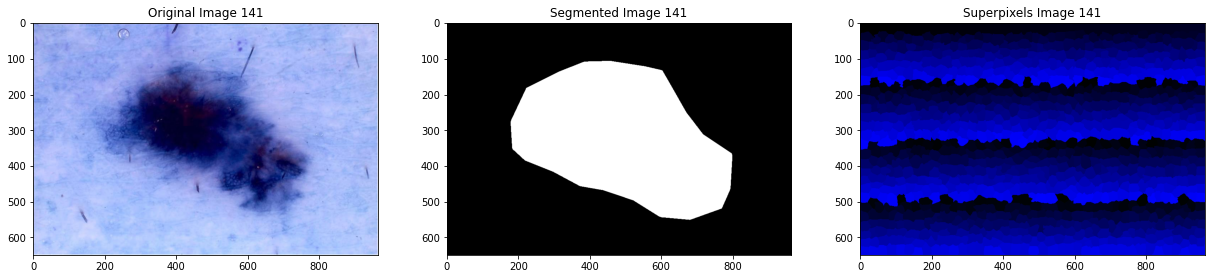

In [5]:
#we visualize a random set of pictures 
i = rd.randint(0,200)
#We plot the three corresponding images
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (21, 5))
ax1.imshow(original_images[i])
ax1.set_title("Original Image "+str(i))
ax2.imshow(segmentated_images[i], cmap = "gray")
ax2.set_title("Segmented Image "+str(i))
ax3.imshow(superpixels_images[i])
ax3.set_title("Superpixels Image "+str(i))

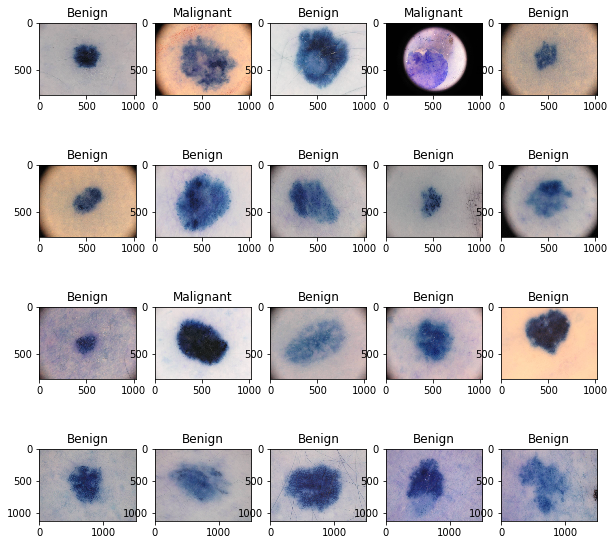

In [6]:
#we can also display the first 20 images 
fig=plt.figure(figsize=(10, 10))
for i in range(1,21):
    ax = fig.add_subplot(4, 5, i)
    if images_info["melanoma"][i] == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(original_images[i],interpolation='nearest')#
plt.show()

# Features extraction

In this part, the objective is to extract some fetaures for each image of the database. We are going tu use
can use **geometrical** / **morphological** descriptors as well as **intensity** / **texture** descriptors.

**Medical Diagnosis:**
To recognize melanoma cases, dermatologists compare and analyze a multiple signs of
each tumor. Mostly, they use two scoring systems based on visual characteristics to
recognize the melanoma tissue, which are ABCDE rule and Glascow 7-point
checklist / 7-point checklist .
These two scoring systems are well known by medical experts and they constitute
the basic methods of comparison for image processing experts. The features
used in these systems are also explored separately in the goal of melanoma recognition.

*We are going to use this knowledge to extract the known features primarely and use this code to extract aditionnal features*

**ABCD rule:**
The skin cancer foundation explained the ABCD rule, called also ABCDE rule when the evolving feature is available. The meaning used for each case is explained and illustrated below:


*   Asymmetry (A): The pigment is considered asymmetric if by drawing one vertical or horizontal line, the two parts of the mole will not be similar.

*   Border (B): More the pigment border is not smooth, more it can be considered as malignant case.


*   Color (C): Most benign pigments have one color (often brown color). Melanoma has a variety of colors (black, red, blue and/or wight).


*   Diameter (D): Benign pigments have usually smaller diameter than malignant
ones. Melanoma is often greater than 6 mm, but it can be smaller.

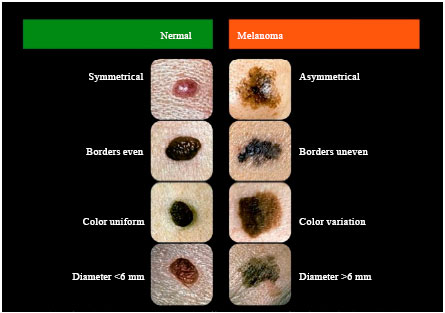



## Geometric/morphologic features from segmented images 

In this section, we shall describe the binary segmented image with geometrical and morphological descriptors. To achieve this, we will use Region Propreties as done in Project 1. In order to do that, we shall code the function GetFeatures which, given an image with a binary region, extracts the ShapeFeat feature vector. We extract:

**Asymetry:**
Asymmetry of the lesion is characterized through asymmetric index (AI) and eccentricity. In order to obtain the former parameter, AI, we first find the difference (the non-overlapping region) between the lesion image and its horizontal flip, and the one between the lesion image and its vertical flip. Then, we compute the ratio between those differences and the total lesion area and finally we take their average. AI can be expressed with the following formula:

$AI=\frac{\frac{image\_area - image\_hflip\_area}{image\_area} + \frac{image\_area - image\_vflip\_area}{image\_area}}{2}$

**Diameter:** 
The diameter of the lesion is computed as the diameter of a circle with the same area as the lesion region.

**Border irregularity:** 
Border irregularity is represented through the so-called compact index (CI), that is computed using the following formula:

$CI=\frac{P^2}{4πA}$
where $P$ is the image perimeter and  is $A$ the image area.

Then using the regionprops function. To get a hold on our shapes of interest we use the following attributes:


*   Area: Number of pixels of the smallest convex polygon that contains the region

*   Eccentricity: Scalar that specifies the eccentricity of the ellipse that has the same second central moments as the region
*   Solidity: Ratio between the area of the region and the Convex Area of the region
*   MinorAxisLength: Length of the minor axis of the ellipse that has the same second central moments as the region
*   MajorAxisLength: Length of the major axis of the ellipse that has the same second central moments as the region
*   Extent: Scalar that specifies the ratio of the pixels of the region to the pixels in the bounding box around the region

*  EquivDiameter: Scalar that specifies the diameter of a circle with the same area as the region 
*  Perimeter: Number of points in the contour of the region
FilledArea: Number of pixels belonging to the region after filling its possible holes
*  FilledArea: Number of pixels belonging to the region after filling its possible holes


The function will return a vector with all the descriptors of the ShapeFeat




In [7]:
def GetFeateatures(image):
  '''
  returns the vector of geometric features of a binary image 
  '''
  #Initialise the output
  shapeFeatVector = []

  #Extracting the label and image
  label_img = label(image)
  lesion_region = regionprops(label_img)[0]

  #asymetry
  area_total = lesion_region.area
  img_mask = lesion_region.image
    
  horizontal_flip = np.fliplr(img_mask)
  diff_horizontal = img_mask * ~horizontal_flip

  vertical_flip = np.flipud(img_mask)
  diff_vertical = img_mask * ~vertical_flip
  diff_horizontal_area = np.count_nonzero(diff_horizontal)
  diff_vertical_area = np.count_nonzero(diff_vertical)
  asymm_idx = 0.5 * ((diff_horizontal_area / area_total) + (diff_vertical_area / area_total))
  shapeFeatVector.append(asymm_idx)

  #border irregularity
  compact_index = (lesion_region.perimeter ** 2) / (4 * np.pi * area_total)
  shapeFeatVector.append(compact_index)

  #diameter
  shapeFeatVector.append(lesion_region.equivalent_diameter)


  #Other features 
  shapeFeatVector.append(lesion_region.area)
  shapeFeatVector.append(lesion_region.eccentricity)
  shapeFeatVector.append(lesion_region.perimeter)
  shapeFeatVector.append(lesion_region.extent)
  shapeFeatVector.append(lesion_region.filled_area)
  shapeFeatVector.append(lesion_region.minor_axis_length)
  shapeFeatVector.append(lesion_region.major_axis_length)
  shapeFeatVector.append(lesion_region.major_axis_length / lesion_region.minor_axis_length)
  shapeFeatVector.append(lesion_region.solidity)

  

  return np.array(shapeFeatVector)

In [8]:
#Creating the matrix seg_feat
num_features = 12
num_edges = len(segmentated_images)
seg_feat = np.zeros((num_edges, num_features))

#Looping over the images
for i in range(0, num_edges):
    
    #Extracting the ith image
    img = segmentated_images[i].astype("bool")
    
    #Compute the descriptors usign the fGetShapeFeat function
    shapeFeatVector = GetFeateatures(img)
    
    #Store the feature vector into the matrix seg_feat
    seg_feat[i,:] = shapeFeatVector
    
#Displaying the results as a DataFrame
seg_feat = pd.DataFrame(seg_feat, columns = ['Asymmetric Index',"Equivalent Diameter",'compact_index',"Area", "Eccentricity", "Perimeter", 
                                             "Extent", "Filled area", "Minor Axis Length", 
                                             "Major Axis Length", "R", "Solidity"])
seg_feat.head()

,Asymmetric Index,Equivalent Diameter,compact_index,Area,Eccentricity,Perimeter,Extent,Filled area,Minor Axis Length,Major Axis Length,R,Solidity
0,0.152709,1.459164,681.671777,364956.0,0.757181,2586.885569,0.731926,364956.0,556.405972,851.808557,1.530912,0.968834
1,0.067694,1.701672,260.828939,53432.0,0.436456,1068.915872,0.749923,53432.0,249.034859,276.789839,1.111450,0.927011
2,0.158520,1.964713,549.790519,237402.0,0.597147,2421.010460,0.642384,237402.0,496.327926,618.761026,1.246678,0.915687
3,0.094739,1.460787,576.150005,260712.0,0.433660,2187.655121,0.707612,260712.0,551.560706,612.112946,1.109783,0.955924
4,0.120182,1.198266,585.762482,269484.0,0.666933,2014.410388,0.757791,269484.0,508.604676,682.583151,1.342070,0.986359


## Textural features from original images

**Texture classification** Texture defines the consistency of patterns and colors in an object/image. To classify objects in an image based on texture, we have to look for the consistent spread of patterns and colors in the object’s surface. One of the main methods to characterize (quantify) an image based on texture is the so-called Haralick Texture and it is performed through the computation of the Gray Level Co-occurrence Matrix (GLCM). The main concept behind GLCM is adjacency of pixels in the image: it looks for pairs of adjacent pixel values that occur in an image and keeps recording it over the entire image. There are four types of adjacency and hence four GLCM matrices can be constructed from a single image: Left-to-Right, Top-to-Bottom, Top Left-to-Bottom Right, Top Right-to-Bottom Left.

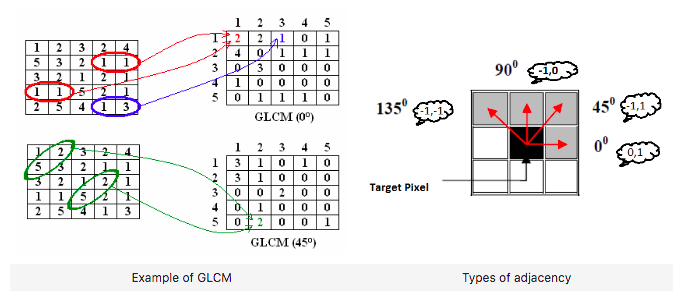

In this work, the GLCM matrix is calculated through the greycomatrix() method of the skimage.feature module. In particular, among its parameters, we set distances to [1], which means that the adjacency distance for each pair of pixels is set to 1, and angles is set to [0, 40°, 90°, 135°] so that we consider all the possible types of adjacency.
The properties are computed as follows:

*   contrast:  is a measure of the local variations
present in an image.
$\sum_{i,j=0}^{levels-1} P_{i,j}(i-j)^2$
*   dissimilarity:$\sum_{i,j=0}^{levels-1}P_{i,j}|i-j|$
*   homogeneity:$\sum_{i,j=0}^{levels-1}\frac{P_{i,j}}{1+(i-j)^2}$
*   ASM:$\sum_{i,j=0}^{levels-1} P_{i,j}^2$
*   energy:$\sqrt{ASM}$
*   correlation: is a measure of image linearity
$\sum_{i,j=0}^{levels-1} P_{i,j}\left[\frac{(i-\mu_i) \
(j-\mu_j)}{\sqrt{(\sigma_i^2)(\sigma_j^2)}}\right]$








In [9]:
def GetTextureFeatures(image):
  Featurevector=[]
  glcm = greycomatrix(image, distances=[1],angles=[0, np.pi/4, np.pi/2, np.pi * 3/2],symmetric=True, normed=True)
  Featurevector.append(greycoprops(glcm, 'dissimilarity')[0, 0])
  Featurevector.append(greycoprops(glcm, 'correlation')[0, 0])
  Featurevector.append(greycoprops(glcm, 'contrast')[0, 0])
  Featurevector.append(greycoprops(glcm, 'homogeneity')[0, 0])
  Featurevector.append(greycoprops(glcm, 'energy')[0, 0])
  Featurevector.append(greycoprops(glcm, 'ASM')[0, 0])
  
  return Featurevector


In [10]:
#Creating the matrix og_feat
num_features = 6
num_edges = len(original_images)
og_feat = np.zeros((num_edges, num_features))

#Looping over the images
for i in range(num_edges):
    
    #Extracting the ith image
    img = original_images[i]
    img = img_as_ubyte(rgb2gray(img))
    #Compute the descriptors usign the fGetShapeFeat function
    Featurevector= GetTextureFeatures(img)
    
    #Store the feature vector into the matrix seg_feat
    og_feat[i,:] = Featurevector
    
#Displaying the results as a DataFrame
og_feat = pd.DataFrame(og_feat, columns = ["dissimilarity", "correlation", "contrast", "homogeneity", "energy", "ASM"])
og_feat.head()

,dissimilarity,correlation,contrast,homogeneity,energy,ASM
0,1.237680,0.999350,6.841045,0.607972,0.070793,0.005012
1,0.917203,0.992939,14.854836,0.721423,0.127875,0.016352
2,1.663630,0.987931,55.893483,0.529300,0.047022,0.002211
3,1.142877,0.999190,6.272240,0.656626,0.102609,0.010529
4,1.773198,0.989983,130.825977,0.672906,0.308417,0.095121


## Intensity descriptors for original pictures  

**Color variegation:** Color variegation is quantified by the normalized standard deviation of red, green and blue components of lesion. They are expressed by the following formulas:

$C_{r}=\frac{σ_{r}}{M_r}$ $C_{b}=\frac{σ_{b}}{M_b}$ $C_{g}=\frac{σ_{g}}{M_g}$

where $σ_{r}$ $σ_{b}$ $σ_{g}$ are respectively the standard deviations of red, green and blue components of lesion area, while $M_r$ $M_b$ $M_g$ are the maximum values of red, green and blue components in lesion region.
The normalization process is important because objects with higher normal skin pigmentation would also tend to show higher pigmentation in the lesion itself and this needs to be accounted for in order to make any comparison between cases.



In [11]:
def GetColorvar(image,segmented):
  '''
  returns the color variegation from the image 
  '''
  #Initialise the output
  intFeatVector = []

  #Extracting the label and image
  label_img = label(segmented)
  lesion_region = regionprops(label_img)[0]

  #Color variegation:
  #return lesion_region.slice
  sliced = image[lesion_region.slice]
  lesion_r = sliced[:, :, 0]
  lesion_g = sliced[:, :, 1]
  lesion_b = sliced[:, :, 2]

  C_r = np.std(lesion_r) / np.max(lesion_r)
  C_g = np.std(lesion_g) / np.max(lesion_g)
  C_b = np.std(lesion_b) / np.max(lesion_b)

  intFeatVector=[C_r,C_g,C_b]

  return intFeatVector

In [12]:
#For original images:
#Creating the matrix og_c
num_features = 3
num_edges = len(original_images)
og_c = np.zeros((num_edges, num_features))

#Looping over the images
for i in range(num_edges):
    
    #Extracting the ith image
    img = original_images[i]
    seg = segmentated_images[i]
    #Compute the descriptors usign the fGetShapeFeat function
    intFeatVector= GetColorvar(img,seg)
    
    #Store the feature vector into the matrix seg_feat
    og_c[i,:] = intFeatVector
    
#Displaying the results as a DataFrame
og_c = pd.DataFrame(og_c, columns = ["C_R_og", "C_G_og", "C_B_og"])
og_c.head()

,C_R_og,C_G_og,C_B_og
0,0.304863,0.289207,0.259326
1,0.255260,0.254055,0.236317
2,0.252701,0.205078,0.107960
3,0.285537,0.255008,0.200829
4,0.256238,0.227519,0.273072


## Number of superpixels

In [13]:
def countSuperpixels(img):
  #Extracting the green component
  green_image = np.reshape(np.array(img[:,:,1]), (1,-1))[0]

  #Extracting the blue component
  blue_image = np.reshape(np.array(img[:,:,2]), (1,-1))[0]
  
  #Significant indexes of the blue component
  indexes = [i for i in range(len(green_image)) if green_image[i] == 3]
    
  #extraction of the superpixels in this layer
  superpixels_layer = blue_image[indexes]
    
  #Removing repeated values
  trim_ = list( dict.fromkeys(superpixels_layer) )
    
  return max(trim_)

**The following code takes a long time to excecute(predictable)**

In [14]:
#Using the superpixels images
num_features = 1
num_edges = len(superpixels_images)
sp_count = np.zeros((num_edges, num_features))

#Looping over the images
for i in range(num_edges):
    
    #Extracting the ith image
    img = superpixels_images[i]
    #Compute the descriptors usign the fGetShapeFeat function
    nb_sp= countSuperpixels(img)
    
    #Store the feature vector into the matrix seg_feat
    sp_count[i] = nb_sp
    
#Displaying the results as a DataFrame
sp_count = pd.DataFrame(sp_count, columns = ['superpixels'])
sp_count.head()

,superpixels
0,227.0
1,214.0
2,225.0
3,222.0
4,226.0


## Feature selection

**Features before selection**

In [15]:
Features=pd.concat([seg_feat, og_feat,og_c,sp_count],axis=1)
Features.head()

,Asymmetric Index,Equivalent Diameter,compact_index,Area,Eccentricity,Perimeter,Extent,Filled area,Minor Axis Length,Major Axis Length,R,Solidity,dissimilarity,correlation,contrast,homogeneity,energy,ASM,C_R_og,C_G_og,C_B_og,superpixels
0,0.152709,1.459164,681.671777,364956.0,0.757181,2586.885569,0.731926,364956.0,556.405972,851.808557,1.530912,0.968834,1.237680,0.999350,6.841045,0.607972,0.070793,0.005012,0.304863,0.289207,0.259326,227.0
1,0.067694,1.701672,260.828939,53432.0,0.436456,1068.915872,0.749923,53432.0,249.034859,276.789839,1.111450,0.927011,0.917203,0.992939,14.854836,0.721423,0.127875,0.016352,0.255260,0.254055,0.236317,214.0
2,0.158520,1.964713,549.790519,237402.0,0.597147,2421.010460,0.642384,237402.0,496.327926,618.761026,1.246678,0.915687,1.663630,0.987931,55.893483,0.529300,0.047022,0.002211,0.252701,0.205078,0.107960,225.0
3,0.094739,1.460787,576.150005,260712.0,0.433660,2187.655121,0.707612,260712.0,551.560706,612.112946,1.109783,0.955924,1.142877,0.999190,6.272240,0.656626,0.102609,0.010529,0.285537,0.255008,0.200829,222.0
4,0.120182,1.198266,585.762482,269484.0,0.666933,2014.410388,0.757791,269484.0,508.604676,682.583151,1.342070,0.986359,1.773198,0.989983,130.825977,0.672906,0.308417,0.095121,0.256238,0.227519,0.273072,226.0


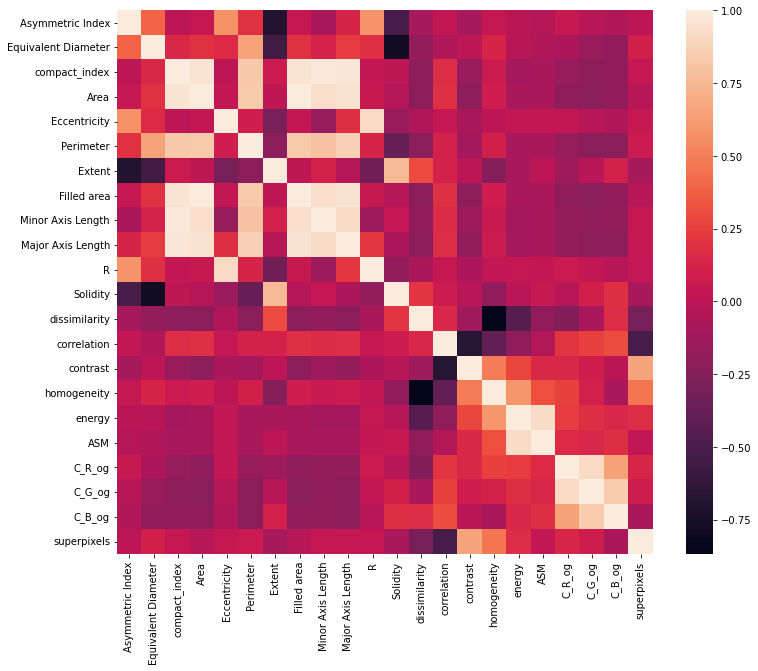

In [16]:
# Correlation heatmap
plt.figure(figsize=(12,10))
sns.heatmap(Features.corr());

**Feature selection**
is the process of reducing the number of input variables when developing a predictive model.

It is desirable to reduce the number of input variables to both reduce the computational cost of modeling and, in some cases, to improve the performance of the model.

Statistical-based feature selection methods involve evaluating the relationship between each input variable and the target variable using statistics and selecting those input variables that have the strongest relationship with the target variable. These methods can be fast and effective, although the choice of statistical measures depends on the data type of both the input and output variables.

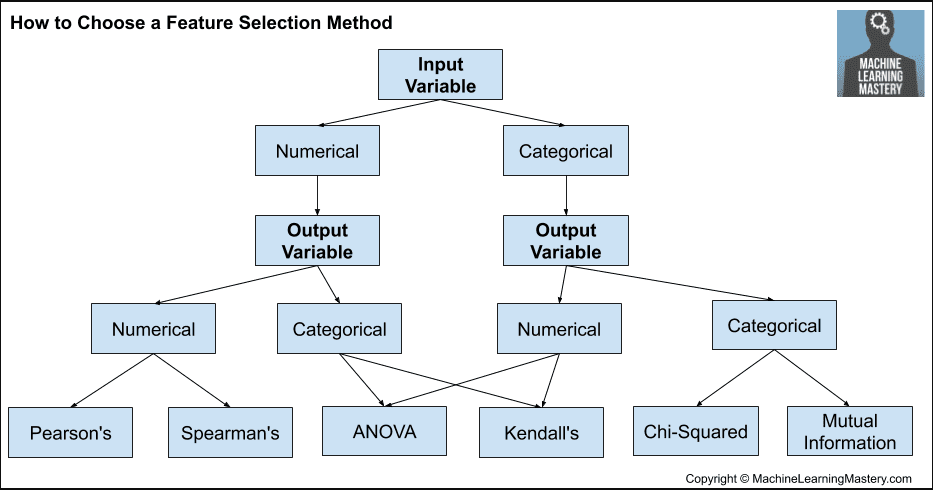

We are dealing with a classification problem with numerical input for this reason we're going to use either the ANOVA method or Kendall's

**ANOVA:** The scikit-learn machine library provides an implementation of the ANOVA f-test in the f_classif() function. This function can be used in a feature selection strategy, such as selecting the top k most relevant features (largest values) via the SelectKBest class.

In [17]:
#Output variable
Y = images_info["melanoma"][:200] #If a cell is benign(0) or melanoma(1)
print("The Y vector is shaped: ", Y.shape)

The Y vector is shaped:  (200,)


In [18]:
Feat_selected = SelectKBest(f_classif, k = 22).fit_transform(Features, Y)
Feat_selected = pd.DataFrame(Feat_selected,columns = ["Feature " + str(i) for i in range(22)])
Feat_selected.head()

,Feature 0,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9,Feature 10,Feature 11,Feature 12,Feature 13,Feature 14,Feature 15,Feature 16,Feature 17,Feature 18,Feature 19,Feature 20,Feature 21
0,0.152709,1.459164,681.671777,364956.0,0.757181,2586.885569,0.731926,364956.0,556.405972,851.808557,1.530912,0.968834,1.237680,0.999350,6.841045,0.607972,0.070793,0.005012,0.304863,0.289207,0.259326,227.0
1,0.067694,1.701672,260.828939,53432.0,0.436456,1068.915872,0.749923,53432.0,249.034859,276.789839,1.111450,0.927011,0.917203,0.992939,14.854836,0.721423,0.127875,0.016352,0.255260,0.254055,0.236317,214.0
2,0.158520,1.964713,549.790519,237402.0,0.597147,2421.010460,0.642384,237402.0,496.327926,618.761026,1.246678,0.915687,1.663630,0.987931,55.893483,0.529300,0.047022,0.002211,0.252701,0.205078,0.107960,225.0
3,0.094739,1.460787,576.150005,260712.0,0.433660,2187.655121,0.707612,260712.0,551.560706,612.112946,1.109783,0.955924,1.142877,0.999190,6.272240,0.656626,0.102609,0.010529,0.285537,0.255008,0.200829,222.0
4,0.120182,1.198266,585.762482,269484.0,0.666933,2014.410388,0.757791,269484.0,508.604676,682.583151,1.342070,0.986359,1.773198,0.989983,130.825977,0.672906,0.308417,0.095121,0.256238,0.227519,0.273072,226.0


**We kept all the features since the results were better**

# Classification

The goal of this part is the classification of skin lesion. The first step is normaliwing the data and splitting it into training and testing set. Then definning multiple ML models to do the classification:


*   SVM (Support Vector Machine) is a discriminative classifier
defined by a separating hyperplane. The labelled training
data are divided by an optimal hyperplane which could be
used for categorizing new, untrained data.
*   LR (Logistic Regression) is a common technique for
solving binary classification problem. It uses a logistic function
to model a binary dependent variable, then use this trained
function to classify untrained data.
*  RF (Random Forest) is a classification technique that
leverage usage of multiple decision trees, each contains leaves
representing class labels and branches representing conjunctions of features that lead to those labels. The trained decision
trees are then used in a randomized fashion (therefore called
Random Forest, in an attempt to overcome overfitting nature
of decision trees) to classify an untrained data
*   DT (Ddecision trees)is a supervised learning technique that has a pre-defined target variable and is most often used in classification problems. This tree can be applied to either categorical or continuous input & output variables. The training process resembles a flow chart, with each internal (non-leaf) node a test of an attribute, each branch is the outcome of that test, and each leaf (terminal) node contains a class label. The uppermost node in the tree is called the root node.
*   K-NN (K nearest neighbor) classifier is simple, quick and effective. The hierarchical structure decomposes the classification task into a set of simpler problems, one at each node of the classification. Feature selection is embedded in the hierarchical framework that chooses the most relevant feature subsets at each node of the hierarchy. 
*  CNN(Convolutional Neural Network) also known as CNN or ConvNet, is a class of neural networks that specializes in processing data that has a grid-like topology, such as an image. A digital image is a binary representation of visual data. It contains a series of pixels arranged in a grid-like fashion that contains pixel values to denote how bright and what color each pixel should be.

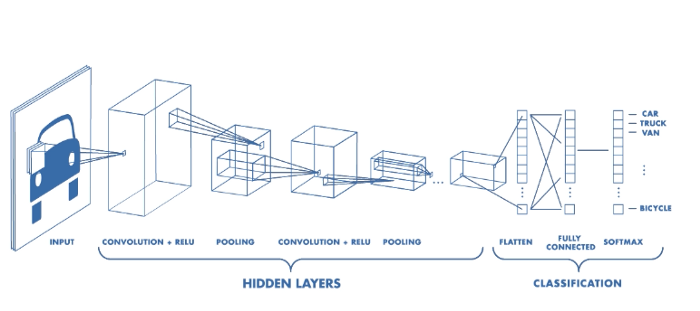









## Split DATA

In [19]:
#Normalization of the data
min_max_scaler = MinMaxScaler()
X = min_max_scaler.fit_transform(Feat_selected)
X = pd.DataFrame(X, columns = Feat_selected.columns)
print("Data normalized.")


#Train Test Split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)
print("Data split.")
print("Train predictor shape: ", X_train.shape)
print("Test predictor shape: ", X_test.shape)

Data normalized.
Data split.
Train predictor shape:  (140, 22)
Test predictor shape:  (60, 22)


## Support vector machines

The main challenge with svms is the choice of kernels. The process is testing the kernels and choosing the one that gives the best results. For this case we're going to use rbf as a reference because they are known to perform very well on a large variety of problems.

In [20]:
#modeling
svm_ = svm.SVC(kernel='rbf', probability=True)
svm_.fit(X_train, Y_train) 

#prediction 
svm_pred = svm_.predict(X_test)

## Logistic Regression

Logistic regression is easier to implement, interpret, and very efficient to train. It can easily extend to multiple classes(multinomial regression) and a natural probabilistic view of class predictions.

In [21]:
#modeling
logistic_regression = LogisticRegression()
logistic_regression.fit(X_train, Y_train)

#predictions
logistic_regression_pred = logistic_regression.predict(X_test)

## Random Forest

**Tune parameters with GridSearchCV**

In [45]:
#model
RandomforestClassifier=RandomForestClassifier()

# Use GridSearchCV to find best parameters for the Random Forest
params = {'n_estimators': [10, 100],
          'max_features': [5, 10, 20],
          'max_depth': [20, 25]}

grid_forest = GridSearchCV(RandomforestClassifier, params, cv=3, n_jobs=-1)

grid_forest.fit(X_train, Y_train)

# View best score and parameters
print('Best score:', grid_forest.best_score_)
print('Best params:', grid_forest.best_params_)

Best score: 0.7784458834412581
Best params: {'max_depth': 20, 'max_features': 5, 'n_estimators': 10}


In [46]:
#modeling
RandomForestClassifier = RandomForestClassifier(max_depth=25,max_features=5,n_estimators=100).fit(X_train, Y_train)

#predictions
RandomForestClassifier_pred=RandomForestClassifier.predict(X_test)

## Decision trees

In [24]:
#model
Decisiontreeclassifier=DecisionTreeClassifier()

# Use GridSearchCV to find best parameters for the Random Forest
params = {'max_depth': np.arange(1,20,1)}

grid_tree = GridSearchCV(Decisiontreeclassifier, params, cv=3, n_jobs=-1)

grid_tree.fit(X_train, Y_train)

# View best score and parameters
print('Best score:', grid_tree.best_score_)
print('Best params:', grid_tree.best_params_)

Best score: 0.7500770891150169
Best params: {'max_depth': 1}


In [25]:
#modeling 
Decisiontreeclassifier = DecisionTreeClassifier(criterion = "entropy", max_depth = 1)
Decisiontreeclassifier=Decisiontreeclassifier.fit(X_train, Y_train)
#predictions
DecisionTreeClassifier_pred=Decisiontreeclassifier.predict(X_test)

## K nearest neighbor

**Optimal K**

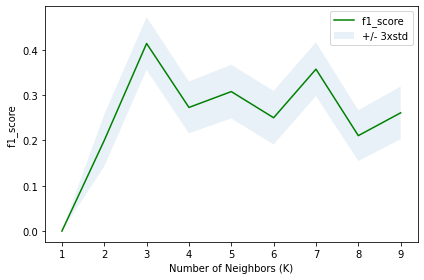

In [26]:
#KNN for different Ks
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))

for n in range(2,Ks):
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train, Y_train)
    yhat = neigh.predict(X_test)
    
    #Computing the accuracy and its standard deviation
    mean_acc[n-1] = metrics.f1_score(Y_test, yhat)
    std_acc[n-1]= np.std(yhat == Y_test)/np.sqrt(yhat.shape[0])

#We plot our results
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('f1_score ', '+/- 3xstd'))
plt.ylabel('f1_score ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

In [27]:
print( "The best f1_score was with", mean_acc.max(), "with k =", mean_acc.argmax()+1) 

The best f1_score was with 0.41379310344827586 with k = 3


In [28]:
#modeling
KNN = KNeighborsClassifier(n_neighbors = 3).fit(X_train, Y_train)
#prediction 
KNN_pred = KNN.predict(X_test)

## Conventional neural networks 

**DATA**

In [29]:
#Reading the files in PROJECT_Data
folder = "/content/drive/MyDrive/Mines Saint-etienne /2A_DATA/IPR/projets /PROJECT_Data/"
files = sorted(os.listdir(directory))[1:]

#Defining the lists
photos, labels = list(), Y


#Extraction loop
for file in files:
    #Image's Id
    id_ = file[:12]

    if file == (id_ + ".jpg"):
      # load image
	    photo = load_img(folder + file, target_size=(200, 200))
	    # convert to numpy array
	    photo = img_to_array(photo)
	    # store
	    photos.append(photo)

# convert to a numpy arrays
photos = np.asarray(photos)

**Split data**

In [30]:
labels=to_categorical(labels, num_classes= 2)
train_images, test_images, train_labels, test_labels = train_test_split(photos, labels, test_size = 0.3, random_state=11)

**Data generator**

In [31]:
BATCH_SIZE = 64

train_generator = ImageDataGenerator(
        zoom_range=2, 
        rotation_range = 90,
        horizontal_flip=True, 
        vertical_flip=True, 
    )

**Model: ResNet50**

ResNet-50 is a convolutional neural network that is 50 layers deep. You can load a pretrained version of the network trained on more than a million images from the ImageNet database. The pretrained network can classify images into 1000 object categories, such as keyboard, mouse, pencil, and many animals. As a result, the network has learned rich feature representations for a wide range of images.

In [32]:
def build_model(backbone, lr=5e-4):
    model = Sequential()
    model.add(backbone)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(2, activation='sigmoid'))
    
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=lr),
        metrics=['accuracy']
    )
    
    return model

In [33]:
K.clear_session()
gc.collect()

resnet = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(200,200,3)
)

model = build_model(resnet ,lr = 1e-4)
model.summary()

94781440/94765736 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 2)                 4098      
                                                         

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [34]:
#overfiting
learn_control = ReduceLROnPlateau(monitor='accuracy', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

**Training & Evaluation**

In [35]:
history = model.fit_generator(
    train_generator.flow(train_images, train_labels, batch_size=BATCH_SIZE),
    steps_per_epoch=train_images.shape[0] / BATCH_SIZE,
    epochs=15,
    validation_data=(test_images, test_labels),
    callbacks=[learn_control]
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/15
2/2 [==============================] - 110s 47s/step - loss: 0.9414 - accuracy: 0.4786 - val_loss: 0.7194 - val_accuracy: 0.5833 - lr: 1.0000e-04
Epoch 2/15
2/2 [==============================] - 98s 47s/step - loss: 0.8082 - accuracy: 0.5429 - val_loss: 0.7031 - val_accuracy: 0.5833 - lr: 1.0000e-04
Epoch 3/15
2/2 [==============================] - 96s 47s/step - loss: 0.8082 - accuracy: 0.6000 - val_loss: 0.6916 - val_accuracy: 0.5667 - lr: 1.0000e-04
Epoch 4/15
2/2 [==============================] - 96s 47s/step - loss: 0.7360 - accuracy: 0.6357 - val_loss: 0.6802 - val_accuracy: 0.6000 - lr: 1.0000e-04
Epoch 5/15
2/2 [==============================] - 111s 53s/step - loss: 0.7179 - accuracy: 0.6429 - val_loss: 0.6675 - val_accuracy: 0.6500 - lr: 1.0000e-04
Epoch 6/15
2/2 [==============================] - 98s 47s/step - loss: 0.7253 - accuracy: 0.6571 - val_loss: 0.6378 - val_accuracy: 0.6833 - lr: 1.0000e-04
Epoch 7/15
2/2 [==============================] - 98s 48s/step

In [36]:
with open('history.json', 'w') as f:
    json.dump(str(history.history), f)

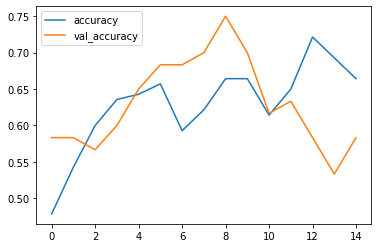

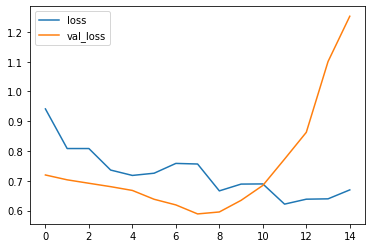

In [37]:
history_df = pd.DataFrame(history.history)
#plot
history_df[[ 'accuracy','val_accuracy']].plot()
history_df[[ 'loss','val_loss']].plot()

**PREDICTION**

In [38]:
CNN_pred = model.predict(test_images)

# Evaluation 

We're going to use the following measures to evaluate the classifier we put in place 

**Confusion Matrix**: it is a table that is often used to describe the performance of a classification model on a set of test data for which the true values are known. The confusion matrix itself is relatively simple to understand, but the related terminology can be confusing!

*   True Positive: We predicted positive and it’s true.
*   True Negative: We predicted negative and it’s true.


*   False Positive: (Type 1 Error) We predicted positive and it’s false.
*   False Negative: (Type 2 Error) We predicted negative and it’s false.

**Accuracy**: is the most intuitive performance measure and it is simply a ratio of correctly predicted observation to the total observations. However, a high accuracy doesn’t mean that our model is best. It is a great measure indeed, but only when we have symmetric datasets where values of false positive and false negatives are almost same.

$Accuracy=\frac{(TP+TN)}{(TP+TN+FN+FP)}$

**Fscore** is the weighted average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account. Intuitively it is not as easy to understand as accuracy, but F is usually more useful than accuracy, especially if we have an uneven class distribution.

**ROC Curve**. The ROC curve is a graphical plot that illustrates the diagnostic ability of a binary class ifier system as its discrimination threshold is varied. We take under consideration the Area Under the Curve. In general, an AUC of 0.5 suggests no discrimination (i.e. ability to diagnose patients with and without the disease or condition based on the test), 0.7 to 0.8 is considered acceptable, 0.8 to 0.9 is considered excellent, and more than 0.9 is considered outstanding.

In [43]:
#The data
min_max_scaler = MinMaxScaler()
X = min_max_scaler.fit_transform(Features)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class method

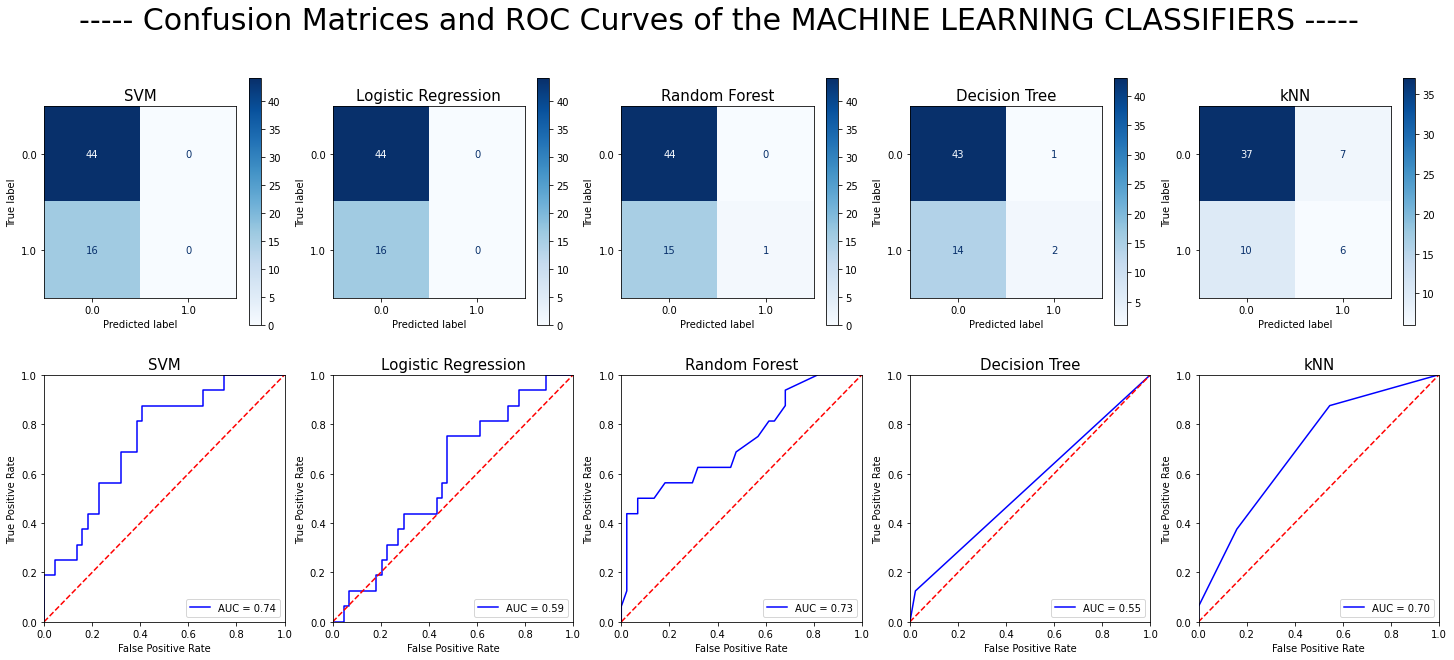

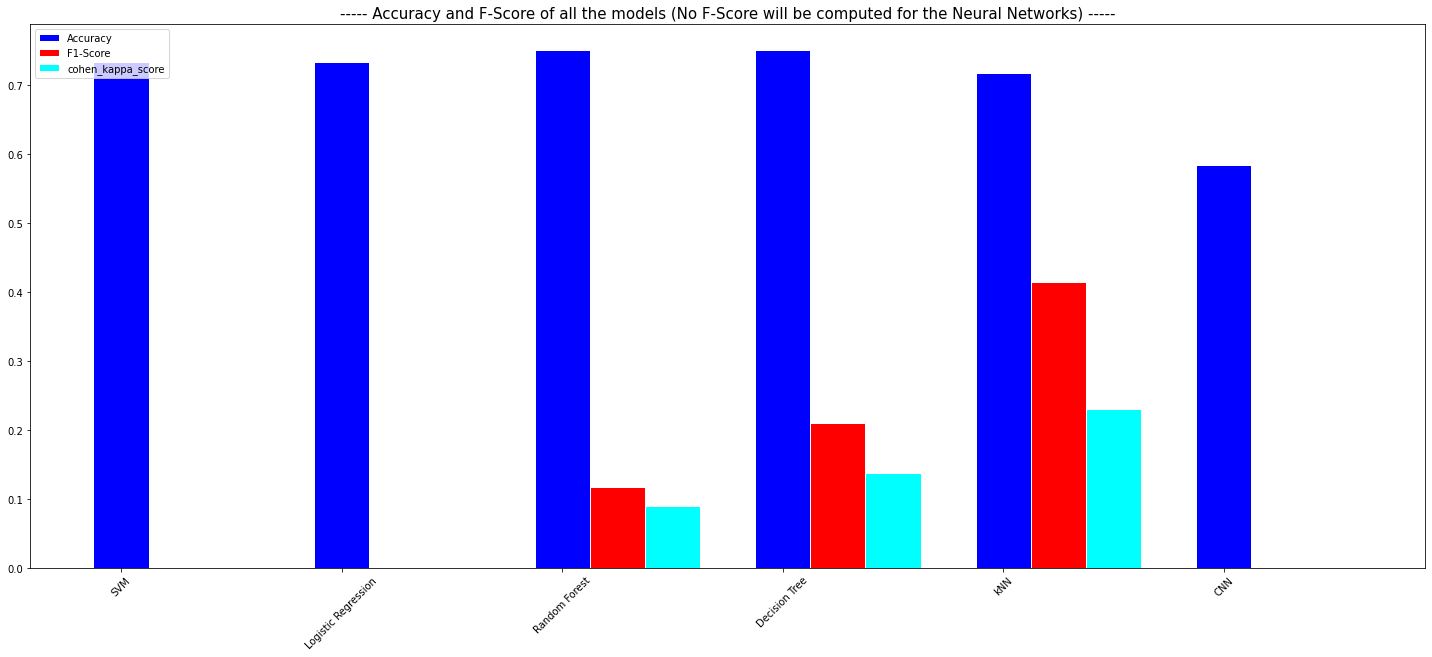

In [47]:
################################### CONFUSION MATRIX AND ROC CURVE ################################################

#Initializing the figure
fig, axs = plt.subplots(2, 5, figsize = (25, 10))

#Gathering the models
models = [svm_, logistic_regression, RandomForestClassifier,Decisiontreeclassifier, KNN]
names = ["SVM","Logistic Regression", "Random Forest","Decision Tree", "kNN"]

#Looping over the models
for i, clf in enumerate(models):

    #Confusion Matrix
    plot_confusion_matrix(clf, X_test, Y_test, cmap='Blues', ax = axs[0,i]) 
    axs[0,i].set_title(names[i], fontsize = 15)

    #ROC Curve
    y_scores = clf.predict_proba(X_test)
    FPR, TPR, threshold = roc_curve(Y_test, y_scores[:, 1])
    roc_auc = auc(FPR, TPR)

    axs[1,i].plot(FPR, TPR, 'b', label = 'AUC = %0.2f' % roc_auc)
    axs[1,i].legend(loc = 'lower right')
    axs[1,i].plot([0, 1], [0, 1],'r--')
    axs[1,i].set_title(names[i], fontsize = 15)
    axs[1,i].set_xlim([0, 1])
    axs[1,i].set_ylim([0, 1])
    axs[1,i].set_ylabel('True Positive Rate')
    axs[1,i].set_xlabel('False Positive Rate')

#Displaying the plot
plt.suptitle("----- Confusion Matrices and ROC Curves of the MACHINE LEARNING CLASSIFIERS -----", fontsize = 30)
plt.show()

###################################################################################################################
print("\n")
print("\n")
################################################ ACCURACY #########################################################

#Initializing
predicted_labels = [svm_pred,logistic_regression_pred, RandomForestClassifier_pred, DecisionTreeClassifier_pred, KNN_pred]
accuracies = []
f1_scores = []
cohenkappa_score=[]
names.append("CNN")


#Looping over the models
for label in predicted_labels:
    accuracies.append(accuracy_score(Y_test, label))
    f1_scores.append(f1_score(Y_test, label))
    cohenkappa_score.append(cohen_kappa_score(Y_test, label))

#Adding the CNN  accuracies
accuracies.append(model.evaluate(test_images, test_labels, verbose=0)[1]) 
f1_scores.append(0)
cohenkappa_score.append(0)

    
# set width of bar
barWidth = 0.25

# Set position of bar on X axis
r1 = np.arange(len(accuracies))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
    
# Make the plot  
plt.figure(figsize = (25, 10))
plt.bar(r1, accuracies, color='blue', width=barWidth, edgecolor='white')
plt.bar(r2, f1_scores, color='red', width=barWidth, edgecolor='white')
plt.bar(r3, cohenkappa_score, color='cyan', width=barWidth, edgecolor='white')


# Add xticks on the middle of the group bars
plt.xticks([j for j in range(len(names))], names, rotation = 45);
plt.legend(["Accuracy", "F1-Score",'cohen_kappa_score'], loc = "upper left")
plt.title("----- Accuracy and F-Score of all the models (No F-Score will be computed for the Neural Networks) -----", 
          fontsize = 15)
plt.show()



# Conclusion:

We notice here that the Decision tree, Random Forest, and Logistic Regression perform really well used on our own extracted data. The CNN did an amazing job at predicting as well but not as good as the other models.

As a matter of fact, and looking at the ROC Curve, the Knn and Random Forest are very accurate.

# References:
[1][Faouzi Adjed. Skin Cancer segmentation and Detection Using Total Variation and Multiresolution
Analysis. Signal and Image processing. Univeristé Paris-Saclay; Université d’Evry-Val-d’Essonne;
UTP Petronas, 2017. English. ffNNT : 2017SACLE042ff. fftel-01813424f](https://hal.archives-ouvertes.fr/tel-01813424/document)

[2][How to Choose a Feature Selection Method For Machine Learning
Brownlee](https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/)

[3][Tri Cong Pham, Giang Son Tran, Thi Phuong Nghiem, Antoine Doucet, Chi Mai Luong, et al.. A
Comparative Study for Classification of Skin Cancer. 2019 International Conference on System Science
and Engineering (ICSSE), Jul 2019, Dong Hoi, Vietnam. pp.267-272, ff10.1109/ICSSE.2019.8823124ff.
ffhal-03025957f](https://hal.archives-ouvertes.fr/hal-03025957/document)

[4][Convolutional Neural Networks, Explained
Mishra](https://towardsdatascience.com/convolutional-neural-networks-explained-9cc5188c4939)